In [ ]:
import os
import json
from google.colab import files, drive, data_table
drive.mount('/content/drive')

# --- Paths ---
# Adjust based on your environment
INPUT_DIR = '/content/'

if not os.path.exists(f'{INPUT_DIR}train_transaction.csv'):
    print("Uploading Credentials & Downloading Data")
    os.environ.pop('KAGGLE_USERNAME', None)
    os.environ.pop('KAGGLE_KEY', None)
    if os.path.exists('/root/.kaggle/kaggle.json'):
        os.remove('/root/.kaggle/kaggle.json')
    if os.path.exists(f'{INPUT_DIR}kaggle.json'):
        os.remove(f'{INPUT_DIR}kaggle.json')

    print("Old credentials cleared.")

    print("Please upload the NEW kaggle.json file now:")
    uploaded = files.upload()

    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("File uploaded and permissions set.")

    print("\nTesting connection...")
    !kaggle competitions list --group general | head -n 3

    print("\nDownloading Data...")
    !kaggle competitions download -c ieee-fraud-detection
    !unzip -o ieee-fraud-detection.zip
    !rm -rf ieee-fraud-detection.zip
    print("Data downloaded and unzipped.")
else:
    print("Data already downloaded and unzipped.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data already downloaded and unzipped.


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/IEEE-CIS Fraud Detection - Submission version', 'r') as f:
    notebook = json.load(f)

total_lines = 0
clean_lines = 0
num_code_cells = 0

for cell in notebook['cells']:
    if cell['cell_type'] == 'code':
        num_code_cells += 1
        lines = cell['source']
        total_lines += len(lines)
        for line in lines:
            if line.strip() and not line.strip().startswith('#'):
                clean_lines += 1

print(f"Number of Code Cells: {num_code_cells}")
print(f"[Total Lines in Code Cells: {total_lines}]")
print(f" !!! --> Clean Code Lines (code only): {clean_lines}!!!")

Number of Code Cells: 13
[Total Lines in Code Cells: 490]
 !!! --> Clean Code Lines (code only): 313!!!


# IEEE-CIS Fraud Detection: A Production-Grade Pipeline
### *From Raw Data to Dynamic Risk Thresholding*

## 1. Introduction & Objectives
In this notebook, we build a robust fraud detection system for high-velocity retail transactions.
Unlike standard Kaggle approaches, we focus on **Production Readiness**:
1.  **Leakage-Free Architecture:** Strict time-series splitting.
2.  **Hybrid Modeling:** Combining Supervised (LightGBM) and Unsupervised (Isolation Forest) signals.
3.  **Business Logic:** Translating probabilities into financial decisions using a Dynamic Utility Threshold.

## 2. Infrastructure Setup

In [ ]:
# Code Cell 1 - Infrastructure Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn
import matplotlib as mpl
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score
import os
import gc
import random

# --- Configuration & Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

# package versions
print(f'numpy: {np.__version__} *', f'pandas: {pd.__version__} *',
      f'sklearn: {sklearn.__version__} *', f'mpl: {mpl.__version__} *',
      f'sns: {sns.__version__} *', f'lightgbm: {lgb.__version__}')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# --- Utility: Memory Reduction ---
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: df[col] = df[col].astype(np.float32)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print(f'Mem. usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

# --- Data Loading ---
print("Loading Data...")
train_id = pd.read_csv(f'{INPUT_DIR}train_identity.csv')
train_trans = pd.read_csv(f'{INPUT_DIR}train_transaction.csv')

df_in = pd.merge(train_trans, train_id, on='TransactionID', how='left')

del train_id, train_trans
gc.collect()

print(f"Initial Shape: {df_in.shape}")
df_in = reduce_mem_usage(df_in)

numpy: 2.0.2 * pandas: 2.2.2 * sklearn: 1.6.1 * mpl: 3.10.0 * sns: 0.13.2 * lightgbm: 4.6.0
Loading Data...
Initial Shape: (590540, 434)
Mem. usage decreased to 1044.70 Mb (46.6% reduction)


In [ ]:
# General overview DF
def describe_2(data):
    display(data.describe().T.style.background_gradient(axis=0,cmap=sns.light_palette('blue', as_cmap=True)))

def head_2(data, heaD=2, samplE=False, fraC=0.2, rowS=10):
    pd.set_option('min_rows', rowS)
    try:
        pd.set_option("max_column", data.shape[1])
    except:
        pd.reset_option("^display")
    if samplE:
        display(data.sample(frac=fraC).head(heaD))
    else:
        display(data.head(heaD))
    print(data.shape)

In [ ]:
df_in = df_in.sort_values('TransactionDT').reset_index(drop=True)
split_idx = int(len(df_in) * 0.8)
df = df_in.iloc[:split_idx].copy()

train_main_cols = [
    'TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
    'ProductCD', 'DeviceType', 'DeviceInfo']
display(df.info())
display(df[train_main_cols].info())
describe_2(df)
head_2(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472432 entries, 0 to 472431
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(399), int16(1), int32(2), int8(1), object(31)
memory usage: 835.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472432 entries, 0 to 472431
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   472432 non-null  int32  
 1   isFraud         472432 non-null  int8   
 2   TransactionDT   472432 non-null  int32  
 3   TransactionAmt  472432 non-null  float32
 4   ProductCD       472432 non-null  object 
 5   DeviceType      117638 non-null  object 
 6   DeviceInfo      99536 non-null   object 
dtypes: float32(1), int32(2), int8(1), object(3)
memory usage: 16.7+ MB


None

,count,mean,std,min,25%,50%,75%,max
TransactionID,472432.000000,3223215.500000,136379.515524,2987000.000000,3105107.750000,3223215.500000,3341323.250000,3459431.000000
isFraud,472432.000000,0.035135,0.184122,0.000000,0.000000,0.000000,0.000000,1.000000
TransactionDT,472432.000000,5715961.441564,3559869.184339,86400.000000,2310158.250000,5592303.500000,8745778.500000,12192842.000000
TransactionAmt,472432.000000,134.401367,237.559601,0.251000,42.950001,68.949997,125.000000,31937.390625
card1,472432.000000,9867.868400,4899.160178,1000.000000,6019.000000,9633.000000,14128.000000,18396.000000
card2,465407.000000,362.861267,158.112366,100.000000,210.000000,361.000000,512.000000,600.000000
card3,471609.000000,153.304611,11.499381,100.000000,150.000000,150.000000,150.000000,231.000000
card5,469279.000000,199.594727,40.809792,100.000000,166.000000,226.000000,226.000000,237.000000
addr1,418671.000000,290.470703,101.890335,100.000000,204.000000,299.000000,330.000000,540.000000
addr2,418671.000000,86.772591,2.909368,10.000000,87.000000,87.000000,87.000000,102.000000


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(472432, 434)


## 3. Strategic EDA: Hypothesis Driven Analysis
Instead of exploring randomly, we test specific hypotheses to justify our feature engineering strategy.

### Hypothesis A: "Fraudsters operate during sleeping hours."
* **Logic:** Legitimate users buy during the day. Bots/Attackers operate globally or via scripts at odd hours.
* **Action:** If validated, we will create `hour` and `hour_risk` features.

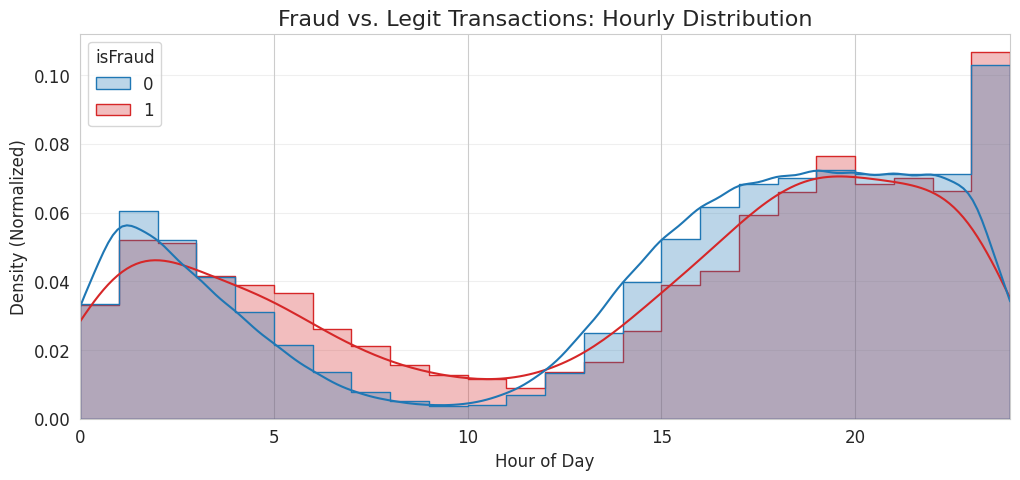

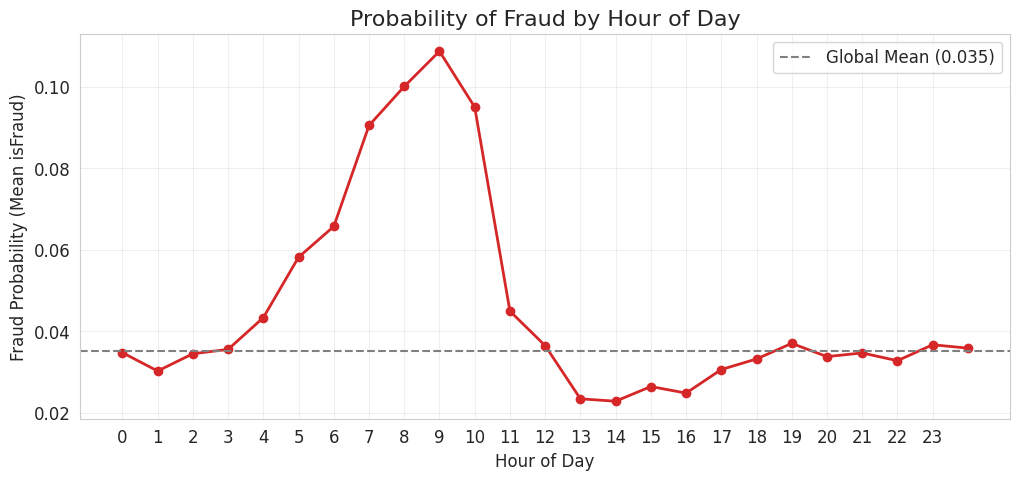

Insight: Fraud rate spikes significantly during early morning hours (4-9 AM).
Top 5 Riskiest Hours:
hour
9.0     0.108684
8.0     0.100039
10.0    0.094980
7.0     0.090465
6.0     0.065710
Name: isFraud, dtype: float64


In [ ]:
# Code Cell 2: Strategic EDA - Hypothesis A

# Create temporary hour feature
df['hour'] = ((df['TransactionDT'] / 3600) % 24).round()

plt.figure(figsize=(12, 5))
sns.histplot(data=df, x='hour', hue='isFraud', stat='density',
             common_norm=False, bins=24, kde=True, alpha=0.3,
             palette=['#1f77b4', '#d62728'], element="step")
plt.title('Fraud vs. Legit Transactions: Hourly Distribution', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Density (Normalized)', fontsize=12)
plt.xlim(0, 24)
plt.grid(axis='y', alpha=0.3)
plt.show()


fraud_rate_per_hour = df.groupby('hour')['isFraud'].mean()
global_mean = df['isFraud'].mean()

plt.figure(figsize=(12, 5))
plt.plot(fraud_rate_per_hour.index, fraud_rate_per_hour.values, marker='o', color='#d62728', linewidth=2)
plt.axhline(y=global_mean, color='gray', linestyle='--', label=f'Global Mean ({global_mean:.3f})')
plt.title('Probability of Fraud by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Fraud Probability (Mean isFraud)', fontsize=12)
plt.xticks(range(0, 24))  # Ensure all hours are displayed on X-axis
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print the riskiest hours
print("Insight: Fraud rate spikes significantly during early morning hours (4-9 AM).")
print("Top 5 Riskiest Hours:")
print(fraud_rate_per_hour.sort_values(ascending=False).head(5))

### Hypothesis B: "Missing Data is a Signal, not an Error."
* **Logic:** Certain features (like Vesta's `V` columns or `M4`) might be missing because the enrichment service failed to verify the user.
* **Action:** We will check if `NULL` values correlate with fraud.

In [ ]:
# Code Cell 3: Strategic EDA - Hypothesis B

# Analyze the V-Feature Cluster (V293-V309)
v_cluster = ['V293', 'V294', 'V295', 'V306', 'V307', 'V308']
df['V_Cluster_Nulls'] = df[v_cluster].isnull().sum(axis=1)
df = df.copy()

stats = df.groupby('V_Cluster_Nulls')['isFraud'].mean()
print("--- Fraud Rate by Number of Missing V-Features ---")
print(stats)

# Analyze M4
m4_stats = df.groupby(df['M4'].isnull())['isFraud'].mean()
print("\n--- M4 Missingness Signal ---")
print(f"Fraud Rate if M4 Present: {m4_stats[False]:.4f}")
print(f"Fraud Rate if M4 Missing: {m4_stats[True]:.4f}")

--- Fraud Rate by Number of Missing V-Features ---
V_Cluster_Nulls
0    0.035132
6    0.166667
Name: isFraud, dtype: float64

--- M4 Missingness Signal ---
Fraud Rate if M4 Present: 0.0504
Fraud Rate if M4 Missing: 0.0187


### Hypothesis C: "Contextual Anomalies (Spikes) indicate Fraud."
* **Logic:** A $200 transaction is normal for some, but huge for others. We need to measure deviation from the user's *own* history.
* **Action:** We will prove that `TransactionAmt / Card_Median` is a strong predictor.

In [ ]:
# Code Cell 4: Strategic EDA - Hypothesis C

# Sort data by time to ensure correct sequential calculation
df = df.sort_values('TransactionDT')

# 1. Amount Differential (The "Jump" feature)
# Captures the "Test & Drain" pattern: Small transaction followed by a huge one.
df['amt_diff'] = df.groupby('card1')['TransactionAmt'].diff()
# 2. Calculate temporary median per card
df['card1_median'] = df.groupby('card1')['TransactionAmt'].transform('median')
# 3. We calculate the standard deviation of the amount over the last 3 transactions
# Fills NaN with bfill, and 0 (for the first transaction)
df['rolling_3_std'] = df.groupby('card1')['TransactionAmt'].transform(lambda x: x.rolling(3).std().bfill().fillna(0))
# 4. Calculate temporary median per card
df['amt_ratio'] = df['TransactionAmt'] / df['card1_median']
# 5. Calculate the time difference (in seconds) since the last transaction for the same card
# - groupby('card1'): We look at each user individually
# - ['TransactionDT'].diff(): Calculates Current_Time - Previous_Time
df['time_since_last_trans'] = df.groupby('card1')['TransactionDT'].diff()
df['curr_to_diff_ratio'] = (df['TransactionAmt'] / df['amt_diff']).replace({np.inf: 0, -np.inf: 0, None: 0})

# Compare Ratios
print("--- Mean Ratio: Legit vs Fraud ---")
print(df.groupby('isFraud')['amt_ratio'].mean())

print("\n--- Median Volatility (Std) for Legit vs Fraud ---")
print(df.groupby('isFraud')['rolling_3_std'].median())

print("\n--- Top 10% Extreme Ratios (90th Quantile) ---")
print(df.groupby('isFraud')['amt_ratio'].quantile(0.9))

print("\n--- Mean Amt to Diff Ratio (Current vs AmtDiff) ---")
print(df.groupby('isFraud')['curr_to_diff_ratio'].mean())

# Let's look at the extremes: Frequent attacks vs Normal behavior
print("\n--- Median Time (Seconds) Since Last Transaction ---")
print(df.groupby('isFraud')['time_since_last_trans'].median())

del df
gc.collect()

--- Mean Ratio: Legit vs Fraud ---
isFraud
0    1.680061
1    1.935938
Name: amt_ratio, dtype: float32

--- Median Volatility (Std) for Legit vs Fraud ---
isFraud
0    43.078417
1    34.883501
Name: rolling_3_std, dtype: float64

--- Top 10% Extreme Ratios (90th Quantile) ---
isFraud
0    3.299270
1    3.969402
Name: amt_ratio, dtype: float64

--- Mean Amt to Diff Ratio (Current vs AmtDiff) ---
isFraud
0    0.284052
1    0.942016
Name: curr_to_diff_ratio, dtype: float32

--- Median Time (Seconds) Since Last Transaction ---
isFraud
0    5740.0
1    3173.0
Name: time_since_last_trans, dtype: float64


0

## 4. Leakage-Free Pipeline Architecture
To simulate a real production environment, we separate the process into two distinct phases:
1.  **`fit_pipeline_stats` (The Learner):** Learns global statistics (Means, Counts, Medians) **only** from the Training set.
2.  **`transform_pipeline_enhanced` (The Transformer):** Applies these statistics to Train, Validation, and Test sets equally. It also adds "Velocity" features (Rolling windows) which are time-safe.

**Advanced Method:** We inject an **Unsupervised Anomaly Score** (Isolation Forest) as a feature into the Supervised Model.

In [ ]:
# Code Cell 5: Feature Engineering Pipeline

# --- Configuration ---
CAT_COLS = ['card1', 'card2', 'card4', 'card6', 'ProductCD', 'addr1', 'P_emaildomain', 'card1_addr1']
V_CLUSTER = ['V293', 'V294', 'V295', 'V306', 'V305', 'V304', 'V303', 'V307', 'V308', 'V309']

def fit_pipeline_stats(df_train):
    """
    Calculates global statistics on the TRAIN set only to avoid leakage.
    """
    stat_map = {}

    # 1. Frequency Encoding Maps
    df_train['card1_addr1'] = df_train['card1'].astype(str) + '_' + df_train['addr1'].astype(str)
    for col in CAT_COLS:
        stat_map[f'freq_{col}'] = df_train[col].astype(object).value_counts(normalize=True).to_dict()

    # 2. Target Encoding for Hour Risk
    df_temp = df_train.copy()
    df_temp['hour'] = ((df_temp['TransactionDT'] / 3600) % 24).astype(int)
    stat_map['hour_risk'] = df_temp.groupby('hour')['isFraud'].mean().to_dict()

    # 3. Global Median for Context
    stat_map['card1_median_amt'] = df_train.groupby('card1')['TransactionAmt'].median().to_dict()

    return stat_map

def transform_pipeline_enhanced(df, stat_map, iso_forest_model=None):
    """
    Applies transformations + Isolation Forest Score.
    """
    df = df.copy()

    # --- A. Time Features ---
    df['hour'] = ((df['TransactionDT'] / 3600) % 24).astype(int)
    df['hour_risk'] = df['hour'].map(stat_map['hour_risk']).fillna(0.035)

    # --- B. Frequency Encoding ---
    df['card1_addr1'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str)
    for col in CAT_COLS:
        df[f'{col}_freq'] = df[col].astype(object).map(stat_map[f'freq_{col}']).astype(float).fillna(0)

    # --- C. Null Signals ---
    df['M4_is_missing'] = df['M4'].isnull().astype(int)
    df['V_Cluster_Nulls'] = df[V_CLUSTER].isnull().sum(axis=1)

    # --- D. Context Aggregations ---
    # Ratio of current Amt to the User's Historical Median (from Train)
    df['card1_median_amt_train'] = df['card1'].map(stat_map['card1_median_amt']).astype(float)
    df['Amt_to_Train_Median_Ratio'] = df['TransactionAmt'] / df['card1_median_amt_train']

    # --- E. Velocity & Time Series (Safe: Backward looking only) ---
    df = df.sort_values('TransactionDT')

    # Time since last transaction
    df['time_since_last_trans'] = df.groupby('card1')['TransactionDT'].diff().fillna(0)

    # Volatility (Rolling Standard Deviation)
    df['rolling_3_std'] = df.groupby('card1')['TransactionAmt'].transform(lambda x: x.rolling(3).std().bfill().fillna(0))

    # Amount Diff & Ratio & Decimal Sig.
    df['amt_diff'] = df.groupby('card1')['TransactionAmt'].diff().fillna(0)
    df['curr_to_diff_ratio'] = (df['TransactionAmt'] / (df['amt_diff'].abs() + 1)).replace({np.inf: 0, -np.inf: 0, None: 0})
    df['TransactionAmt_decimal'] = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).astype(int)

    # --- F. Isolation Forest Anomaly Score ---
    if iso_forest_model:
        # Must use EXACTLY the same features used during fit
        iso_features = ['TransactionAmt', 'card1_freq', 'addr1_freq', 'V285', 'hour_risk']
        X_iso = df[iso_features].fillna(-1)
        df['anomaly_score'] = iso_forest_model.decision_function(X_iso)

    return df

## 5. Execution & Time-Series Split
We use a strict temporal split (Train on Past, Validate on Future) to simulate real-world performance.

In [ ]:
# Code Cell 6: Execution & Time-Series Split

# 1. Prepare Split
df_ = df_in.sort_values('TransactionDT').reset_index(drop=True)

train_df = df_.iloc[:split_idx].copy()
val_df = df_.iloc[split_idx:].copy()

del df_
gc.collect()

print(f"Train Samples: {len(train_df)} | Validation Samples: {len(val_df)}")

# 2. FIT Phase (Learn Statistics)
print("Learning Global Statistics...")
pipeline_stats = fit_pipeline_stats(train_df)

# 3. Train Unsupervised Model (Isolation Forest)
print("Training Isolation Forest (Unsupervised)...")
# Prepare specific features for IsoForest
iso_cols = ['TransactionAmt', 'card1_freq', 'addr1_freq', 'V285', 'hour_risk']
tmp_train = train_df.copy()
tmp_train['hour'] = ((tmp_train['TransactionDT'] / 3600) % 24).astype(int)
tmp_train['hour_risk'] = tmp_train['hour'].map(pipeline_stats['hour_risk']).fillna(0.035)
tmp_train['addr1_freq'] = tmp_train['addr1'].astype(object).map(pipeline_stats[f'freq_addr1']).astype(float).fillna(0)
tmp_train['card1_freq'] = tmp_train['card1'].astype(object).map(pipeline_stats[f'freq_card1']).astype(float).fillna(0)
X_iso_train = tmp_train[iso_cols].fillna(-1)

iso_model = IsolationForest(n_estimators=150, contamination=0.035, random_state=SEED, n_jobs=-1)
iso_model.fit(X_iso_train)

# 4. TRANSFORM Phase
print("Applying Transformations to Train & Val...")
train_df = transform_pipeline_enhanced(train_df, pipeline_stats, iso_model)
val_df = transform_pipeline_enhanced(val_df, pipeline_stats, iso_model)

del tmp_train, X_iso_train
gc.collect()

Train Samples: 472432 | Validation Samples: 118108
Learning Global Statistics...
Training Isolation Forest (Unsupervised)...
Applying Transformations to Train & Val...


23

## 6. LightGBM Training
We optimize for **PR-AUC (Precision-Recall)** because the dataset is highly imbalanced (Fraud ~3.5%).
We add Regularization (L1/L2) to prevent overfitting on noise.

In [ ]:
# Code Cell 7: Training

# Feature Selection
drop_cols = ['isFraud', 'TransactionID', 'TransactionDT', 'card1', 'card2', 'card4', 'card6', 'card1_addr1',
             'ProductCD', 'addr1', 'P_emaildomain', 'M4'] + V_CLUSTER + ['card1_median_amt_train']

X_train = train_df.drop(columns=drop_cols, errors='ignore').select_dtypes(include=[np.number])
y_train = train_df['isFraud']

X_val = val_df.drop(columns=drop_cols, errors='ignore').select_dtypes(include=[np.number])
y_val = val_df['isFraud']

# --- 1. Calculate the Components ---

# A. Business Weight (Linear Capped at $500) + (Log Value)
# Why? We want $100 to be 20x more important than $5 (Linear).
# But we don't want a $3000 transaction to explode the gradients.
w_business = train_df['TransactionAmt'].clip(lower=1, upper=500) + np.log1p(train_df['TransactionAmt'])

# B. Class Weight (Manual Calculation)
# Instead of using 'is_unbalance=True', we calculate the ratio ourselves.
# This gives us control to combine it with business weight.
neg_count, pos_count = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count  # Roughly ~28 for this dataset

# Create a vector where Frauds get ~28 and Legit get 1
w_class = np.where(y_train == 1, scale_pos_weight, 1.0)

# --- 2. Combine into Composite Weight ---
# A fraud of $1000 will have huge weight. A legit of $5 will have tiny weight.
final_weights = w_business * w_class

print("Training with Composite Weights...")
print(f"Min Weight: {final_weights.min():.2f}")
print(f"Max Weight: {final_weights.max():.2f}")

# --- 3. Model Definition (CRITICAL CHANGES) ---
model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=2000,
    learning_rate=0.015,

    # --- Complexity ---
    num_leaves=64,
    max_depth=-1,

    # --- Robustness (The Real Regularization) ---
    min_child_samples=50,
    colsample_bytree=0.7,
    subsample=0.7,
    subsample_freq=1,

    # --- Standard Reg ---
    reg_alpha=0.5,
    reg_lambda=0.5,
    random_state=SEED,
    n_jobs=-1
)
    # is_unbalance=False,        <--- IMPORTANT: Turn this OFF! We handled it manually in weights.
    # class_weight=None,         <--- IMPORTANT: Turn this OFF!

# --- 4. Training ---
model.fit(
    X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
    sample_weight=final_weights, # Injecting our smart composite weights
    eval_metric=['average_precision', 'auc'],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

Training with Composite Weights...
Min Weight: 1.22
Max Weight: 13965.67
[LightGBM] [Info] Number of positive: 16599, number of negative: 455833
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.568938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34311
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 405
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529033 -> initscore=0.116263
[LightGBM] [Info] Start training from score 0.116263
Training until validation scores don't improve for 100 rounds
[100]	training's average_precision: 0.92665	training's auc: 0.910816	training's binary_logloss: 0.438077	valid_1's average_precision: 0.435532	valid_1's auc: 0.877474	valid_1's binary_logloss: 0.448082
[200]	training's average_precision: 0.944139	training's auc: 0.933091	training's binary_logloss: 0.364866	valid_1's average_precision: 0.460916	valid_1's auc: 0.892805

LGBMClassifier(colsample_bytree=0.7, learning_rate=0.015, min_child_samples=50,
               n_estimators=2000, n_jobs=-1, num_leaves=64, objective='binary',
               random_state=42, reg_alpha=0.5, reg_lambda=0.5, subsample=0.7,
               subsample_freq=1)

## 7. Performance Evaluation
We look at Feature Importance to validate our engineering efforts, and final Scores.

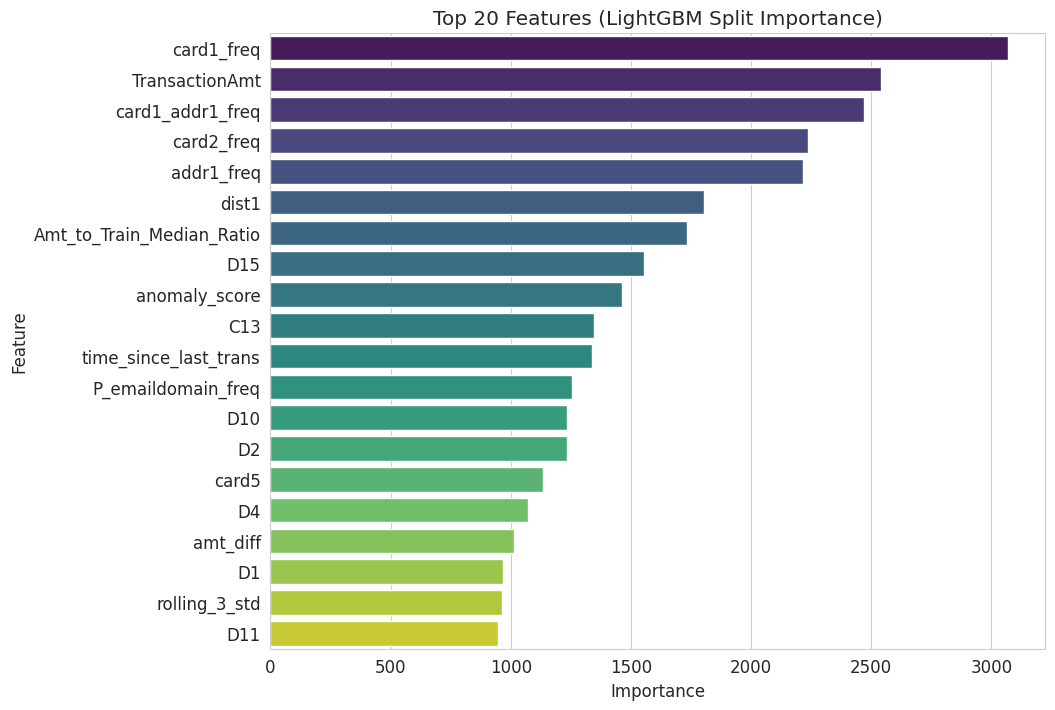


Final ROC-AUC: 0.9107
Final PR-AUC:  0.5062


In [ ]:
# Code Cell 7: Evaluation

# 1. Feature Importance
imp_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
imp_df = imp_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=imp_df, hue="Feature", legend=False, palette="viridis")
plt.title('Top 20 Features (LightGBM Split Importance)')
plt.show()

# 2. Final Metrics
preds = model.predict_proba(X_val)[:, 1]
roc = roc_auc_score(y_val, preds)
pr_auc = average_precision_score(y_val, preds)

print(f"\nFinal ROC-AUC: {roc:.4f}")
print(f"Final PR-AUC:  {pr_auc:.4f}")

## 8. The Product Strategy: Dynamic Utility Thresholding

The raw probability output ($P$) is just a signal. To make a business decision, we apply the **Expected Value Framework**.

### The Formula
We intervene only when the Expected Benefit > Expected Cost:
$$P > \frac{C}{V + C}$$

Where:
* $P$: Probability of Fraud.
* $V$: Value of the Item (Cost of False Negative).
* $C$: Cost of Insult/Friction (Cost of False Positive).

### Operational Tiers
1.  **Low Value (Gum):** $V \approx 0 \rightarrow P \approx 1$. **Action:** Never stop.
2.  **High Value (Whiskey):** $V \gg C \rightarrow P \text{ is low}$. **Action:** Lower threshold (e.g., 0.3) for review.
3.  **Action Plan:**
    * **High Confidence:** Auto-Charge / Decline.
    * **Marginal Confidence:** Silent Review (Human-in-the-loop).
    * **Low Confidence:** Approve (Minimizing friction).

## 9. Moving from **"Bot Hunter" to "Money Guardian"**

* #### Standard metrics (AUC/Precision) treat a 5 Dollars fraud and a 5,000 Dollars fraud equally.

* #### This often leads models to focus on "easy wins" (obvious low-value bots) while missing sophisticated high-value theft.

#### **To fix this**, we shift from ranking by **Probability** ($P$) to ranking by **Expected Risk** ($P \cdot V$).

* We test three strategies against a fixed operational budget (e.g., we can only review **2%** or **3.5%** of traffic):
    1.  **Standard (Prob):** Catch the most *confident* fraud (Bot Hunter).
    2.  **Naïve (Amount):** Catch the most *expensive* transactions (Blindly stopping VIPs).
    3.  **Smart (Risk):** Catch the *highest expected loss* (Money Guardian).

In [ ]:
# Code Cell 8: Financial Strategy Comparison

# 1. Setup Data & Calculate Risk
res_df = pd.DataFrame({
    'isFraud': y_val,
    'prob': preds,
    'Amount': df_in.loc[val_df.index, 'TransactionAmt']
})

# The Core Transformation: Risk = Probability * Value
res_df['risk_score'] = res_df['prob'] * res_df['Amount']

def evaluate_financial_strategy(df, threshold_pct):
    """
    Compares strategies based on a fixed 'review budget' (top k%).
    """
    top_k = int(len(df) * threshold_pct)
    total_fraud_money = df[df['isFraud'] == 1]['Amount'].sum()
    total_fraud_count = df['isFraud'].sum()

    print(f"\n{'='*60}")
    print(f"--- OPERATIONAL BUDGET: Review Top {threshold_pct:.1%} ({top_k} Transactions) ---")
    print(f"{'='*60}")

    strategies = {
        'Standard (Sort by Prob)': 'prob',
        'Naïve    (Sort by Amount)': 'Amount',
        'Smart    (Sort by Risk)': 'risk_score'
    }

    for name, sort_col in strategies.items():
        # 1. Sort and cut the top K
        top_trans = df.sort_values(sort_col, ascending=False).head(top_k)

        # 2. Calculate Hits
        caught_money = top_trans[top_trans['isFraud'] == 1]['Amount'].sum()
        caught_count = top_trans['isFraud'].sum()

        # 3. Key Metrics
        money_recall = caught_money / total_fraud_money
        precision = caught_count / len(top_trans) # How many reviews were valid?
        count_recall = caught_count / total_fraud_count

        print(f"\nStrategy: {name}")
        print(f"  > Money Saved:  {money_recall:.2%} (${caught_money:,.0f})")
        print(f"  > Precision:    {precision:.2%} (Valid stops)")

        # 4. Special Logic for the 'Smart' Strategy (The "Lift" Analysis)
        if sort_col == 'risk_score':
            diff = money_recall - count_recall
            print(f"  > Count Recall: {count_recall:.2%}")
            if diff > 0:
                print(f"     SUCCESS!!! Money Recall is {diff*100:.1f}% HIGHER than Count Recall.")
                print(f"     (Model successfully prioritizes high-value theft over bots)")

# --- Execution ---

# Scenario A: Strict Budget (Top 2%)
evaluate_financial_strategy(res_df, 0.02)

# Scenario B: Prior Match (Top 3.5%)
evaluate_financial_strategy(res_df, 0.035)


--- OPERATIONAL BUDGET: Review Top 2.0% (2362 Transactions) ---

Strategy: Standard (Sort by Prob)
  > Money Saved:  28.17% ($171,841)
  > Precision:    65.28% (Valid stops)

Strategy: Naïve    (Sort by Amount)
  > Money Saved:  28.42% ($173,370)
  > Precision:    6.35% (Valid stops)

Strategy: Smart    (Sort by Risk)
  > Money Saved:  47.39% ($289,110)
  > Precision:    22.02% (Valid stops)
  > Count Recall: 12.80%
     SUCCESS!!! Money Recall is 34.6% HIGHER than Count Recall.
     (Model successfully prioritizes high-value theft over bots)

--- OPERATIONAL BUDGET: Review Top 3.5% (4133 Transactions) ---

Strategy: Standard (Sort by Prob)
  > Money Saved:  39.42% ($240,507)
  > Precision:    47.54% (Valid stops)

Strategy: Naïve    (Sort by Amount)
  > Money Saved:  35.28% ($215,224)
  > Precision:    5.27% (Valid stops)

Strategy: Smart    (Sort by Risk)
  > Money Saved:  56.94% ($347,385)
  > Precision:    18.65% (Valid stops)
  > Count Recall: 18.97%
     SUCCESS!!! Money Recall 